In [1]:
import numpy as np
import scipy.io as sio
import time
from offline_online_alg import *
from convergence import *
from with_FEM_MassMatrix import *
from plots import *
from Experimental_Order_Cvg import *

In [2]:
NFine = np.array([256])
Nepsilon = np.array([128])
NCoarse = np.array([4])
k=1
NSamples = 2
dim = np.size(NFine)
Neigen = 3
boundaryConditions = None
alpha = 0.1
beta = 1.
pList = [0.02]
np.random.seed(123)
model ={'name': 'check', 'alpha': alpha, 'beta': beta}
root = 'Data/Testing/'

In [3]:
KOOLOD_MFEM_EigenSolver(NCoarse, NFine, Nepsilon, k, alpha, beta, NSamples, pList, Neigen, model, save_file=False)

[[-1.22474487  1.21329055]
 [ 1.22474487  1.23614588]
 [ 1.22474487 -1.23614588]
 [-1.22474487 -1.21329055]]
[[ 1.17937382  1.25775168]
 [ 1.26950148 -1.21330756]
 [-1.22526662 -1.23572944]
 [-1.22360867  1.19128532]]


/home/kolombag/Documents/gridlod-random-perturbations/venv3/lib/python3.9/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


(array([[4.93890675, 4.93630359]]), array([[5.00771207, 5.00773559]]))

In [2]:
NFine = np.array([256])
Nepsilon = np.array([128])
NCoarse = np.array([4])
k=3
NSamples = 200
dim = np.size(NFine)
Neigen = 3
boundaryConditions = None
alpha = 0.1
beta = 1.
pList = [0.02,0.04,0.06,0.08,0.1]
np.random.seed(123)
model ={'name': 'check', 'alpha': alpha, 'beta': beta}
root = 'Data/Testing/'

In [3]:
convergence(Neigen, NCoarse, NFine, Nepsilon, k, NSamples, pList,alpha,beta, model, solver = "KOOLOD", reference_solver="FEM", save_files = True, plot=False, root=root)

/home/kolombag/Documents/gridlod-random-perturbations/venv3/lib/python3.9/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Root mean square absolute error of λ1:
 [[0.20888689 0.21190762 0.20815876 0.21342898 0.21282144]
 [0.05170348 0.05096097 0.05093016 0.05086584 0.04703973]
 [0.26592088 0.01324184 0.01384334 0.01543668 0.01588931]
 [0.0041768  0.00517801 0.00920758 0.01301415 0.01407429]]
Root mean square absolute error of λ2: 
 [[0.21064419 0.2103374  0.21024757 0.19705266 0.18590307]
 [0.05107938 0.04862843 0.04461893 0.03906692 0.03382689]
 [0.24813353 0.01393327 0.01866146 0.02630502 0.0326057 ]
 [0.00700822 0.00997074 0.01734944 0.02209085 0.02884694]]


(None, None)

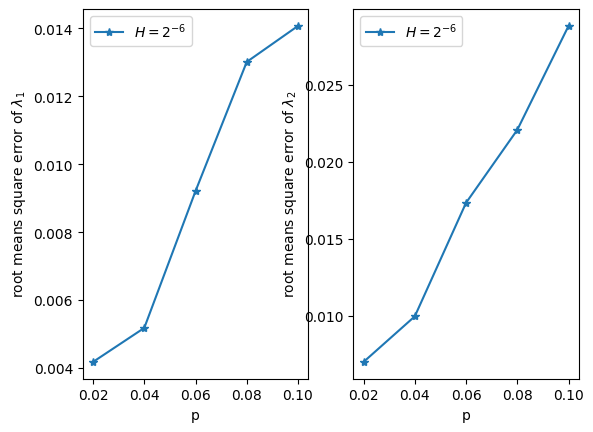

In [3]:
plot_lowest_p(root, p_Convergence=True)

from with_FEM_MassMatrix import *
from convergence import *
from Reference_Solvers import *
from Experimental_Order_Cvg import *
from plots import *
import numpy as np

alpha = 0.1
beta = 1.
NSamples =10
pList = [0.01, 0.02, 0.03, 0.04]
model ={'name': 'check', 'alpha': alpha, 'beta': beta}
NCoarse = np.array([4])
Nepsilon = np.array([128])
NFine = np.array([256])    # Number of "epsilon-blocks" on τ_ε mesh in each direction (1-D array: [x_ε, y_ε, z_ε] if 3D etc.)     # Number of "coarse-blocks" on τ_H mesh in each direction (1-D array: [x_H, y_H, z_H]) # Number of layers in the patch 
Neigen = 3
k =1
np.random.seed(123)
root = 'Data/LOD_1d_randcheck/'

convergence(Neigen, NCoarse, NFine, Nepsilon, k, NSamples, pList,alpha,beta, model, solver = "LOD", reference_solver="FEM", save_files = True, plot=True, root=root)

import numpy as np
import scipy.io as sio
import scipy.sparse.linalg as ln
import time
from gridlod.world import World
from gridlod import util, fem, lod, interp

from gridlod import interp, lod
import sys
sys.path.insert(0, '/home/kolombag/Documents/gridlod-random-perturbations/random_perturbations')
import build_coefficient, lod_periodic, indicator, algorithms

def KOOLOD_MFEM_EigenSolver(NCoarse, NFine, Nepsilon, k, alpha, beta, NSamples, pList, Neigen, model, save_file=True):
    NpFine = np.prod(NFine+1)     # Number of "fine-nodes" on τ_h mesh in each direction (1-D array: [x_h, y_h, z_h])
    NpCoarse = np.prod(NCoarse+1) 
    dim = np.size(NFine)
    
    boundaryConditions = None
    percentage_comp = 0.15
    np.random.seed(123)

    NCoarseElement = NFine // NCoarse
    world = World(NCoarse, NCoarseElement, boundaryConditions)
    xpFine = util.pCoordinates(NFine)

    def computeKmsij(TInd, a, IPatch):
        patch = lod_periodic.PatchPeriodic(world, k, TInd)
        aPatch = lod_periodic.localizeCoefficient(patch,a, periodic=True)

        correctorsList = lod.computeBasisCorrectors(patch, IPatch, aPatch)
        csi = lod.computeBasisCoarseQuantities(patch, correctorsList, aPatch)
        return patch, correctorsList, csi.Kmsij, csi
    
    if model == "model":
        aRefList, KmsijList, muTPrimeList, timeBasis, timeMatrixList = algorithms.computeCSI_offline(world, Nepsilon // NCoarse,k,boundaryConditions,model,correctors=False)                                                             
        aRef = np.copy(aRefList[-1])
        KmsijRef = np.copy(KmsijList[-1])
        muTPrimeRef = muTPrimeList[-1]
        #correctorsRef = correctorsList[-1]

    elif model == "modelincl":
        modeldef = {'name': 'inclvalue', 'bgval': alpha, 'inclval': beta, 'left': left, 'right': right, 'defval': value}
        aRefListdef, KmsijListdef, muTPrimeListdef, _, _ = algorithms.computeCSI_offline(world, Nepsilon // NCoarse, k, boundaryConditions, modeldef)
    else:
        print("Model not yet implemented!")

    basis = fem.assembleProlongationMatrix(world.NWorldCoarse, world.NCoarseElement)
    computePatch = lambda TInd: lod_periodic.PatchPeriodic(world, k, TInd)
    patchT = list(map(computePatch, range(world.NtCoarse)))
    KFullpert = lod_periodic.assembleMsStiffnessMatrix(world, patchT, KmsijRef, periodic=True)
    KLOD_λ1 = np.zeros((len(pList), NSamples))
    KLOD_λ2 = np.zeros((len(pList), NSamples))

    for ii in range(len(pList)):
        p = pList[ii]
        for N in range(NSamples):
            aPert = build_coefficient.build_randomcheckerboard(Nepsilon,NFine,alpha,beta,p)
            #print('CoeffListSize:',aPert.size)
            #print('CoeffList: \n', aPert)

            #true LOD
            if dim == 2:
                middle = world.NWorldCoarse[1] // 2 * world.NWorldCoarse[0] + world.NWorldCoarse[0] // 2
            else: 
                middle = NCoarse[0] // 2
                    
            patchRef = lod_periodic.PatchPeriodic(world, k, middle)
            IPatch = lambda: interp.L2ProjectionPatchMatrix(patchRef)
            computeKmsijT = lambda TInd: computeKmsij(TInd, aPert, IPatch)     

            patchT, correctorsTtrue, KmsijTtrue, _ = zip(*map(computeKmsijT, range(world.NtCoarse)))

            KFulltrue = lod_periodic.assembleMsStiffnessMatrix(world, patchT, KmsijTtrue, periodic=True)

            #combined LOD
            KFullcomb, _,_ = algorithms.compute_combined_MsStiffness(world,Nepsilon,aPert,aRefList,KmsijList,muTPrimeList,k,
                                                                   model,compute_indicator=False)
            correctorsTtrue = tuple(correctorsTtrue)
            modbasistrue = basis - lod_periodic.assembleBasisCorrectors(world, patchT, correctorsTtrue, periodic=True)

            KFullpertup, _ = algorithms.compute_perturbed_MsStiffness(world, aPert, aRef, KmsijRef, muTPrimeRef, k,
                                                                      percentage_comp)
            # FEM Mass Matrix
            MFEM = fem.assemblePatchMatrix(world.NWorldCoarse, world.MLocCoarse) 

            if dim == 2:
                KFulltrue.tolil()
                KFulltrue[np.arange(0, NCoarse[1]*(NCoarse[0]+1)+1, NCoarse[0]+1),:] \
                        += KFulltrue[np.arange(NCoarse[0], np.prod(NCoarse+1), NCoarse[0]+1),:]         # Wrap the LHS-RHS-row values together at LHS-mesh boundary points
                KFulltrue[:, np.arange(0, NCoarse[1] * (NCoarse[0] + 1) + 1, NCoarse[0] + 1)] \
                        += KFulltrue[:, np.arange(NCoarse[0], np.prod(NCoarse + 1), NCoarse[0] + 1)]    # Wrap the LHS-RHS-column values together at LHS-mesh boundary points
                KFulltrue[np.arange(NCoarse[0]+1), :] += KFulltrue[np.arange(NCoarse[1]*(NCoarse[0]+1), np.prod(NCoarse+1)), :]          # Wrap the Bottom - top row-values together at BOTTOM-mesh boundary points 
                KFulltrue[:, np.arange(NCoarse[0] + 1)] += KFulltrue[:, np.arange(NCoarse[1] * (NCoarse[0] + 1), np.prod(NCoarse + 1))]  # Wrap the Bottom - top column-values together at BOTTOM-mesh boundary points
                KFulltrue.tocsc()

                fixed_DoF = np.concatenate((np.arange(NCoarse[1] * (NCoarse[0] + 1), NpCoarse), 
                                                np.arange(NCoarse[0], NpCoarse - 1, NCoarse[0] + 1)))    # All the abandoning boundary points
                free_DoF = np.setdiff1d(np.arange(NpCoarse), fixed_DoF)  # Rest of the nodal indices 
                KLOD_Free_DoF = KFulltrue[free_DoF][:, free_DoF]         # Array after BC applied

                KFullcomb.tolil()
                KFullcomb[np.arange(0, NCoarse[1]*(NCoarse[0]+1)+1, NCoarse[0]+1),:] \
                        += KFullcomb[np.arange(NCoarse[0], np.prod(NCoarse+1), NCoarse[0]+1),:]         # Wrap the LHS-RHS-row values together at LHS-mesh boundary points
                KFullcomb[:, np.arange(0, NCoarse[1] * (NCoarse[0] + 1) + 1, NCoarse[0] + 1)] \
                        += KFullcomb[:, np.arange(NCoarse[0], np.prod(NCoarse + 1), NCoarse[0] + 1)]    # Wrap the LHS-RHS-column values together at LHS-mesh boundary points
                KFullcomb[np.arange(NCoarse[0]+1), :] += KFullcomb[np.arange(NCoarse[1]*(NCoarse[0]+1), np.prod(NCoarse+1)), :]          # Wrap the Bottom - top row-values together at BOTTOM-mesh boundary points 
                KFullcomb[:, np.arange(NCoarse[0] + 1)] += KFullcomb[:, np.arange(NCoarse[1] * (NCoarse[0] + 1), np.prod(NCoarse + 1))]  # Wrap the Bottom - top column-values together at BOTTOM-mesh boundary points
                KFullcomb.tocsc()
                fixed_DoF = np.concatenate((np.arange(NCoarse[1] * (NCoarse[0] + 1), NpCoarse), 
                                                np.arange(NCoarse[0], NpCoarse - 1, NCoarse[0] + 1)))    # All the abandoning boundary points
                free_DoF = np.setdiff1d(np.arange(NpCoarse), fixed_DoF)  # Rest of the nodal indices 
                KOOLOD_Free_DoF = KFullcomb[free_DoF][:, free_DoF]  

                KFullpertup.tolil()
                KFullpertup[np.arange(0, NCoarse[1]*(NCoarse[0]+1)+1, NCoarse[0]+1),:] \
                        += KFullcomb[np.arange(NCoarse[0], np.prod(NCoarse+1), NCoarse[0]+1),:]         # Wrap the LHS-RHS-row values together at LHS-mesh boundary points
                KFullpertup[:, np.arange(0, NCoarse[1] * (NCoarse[0] + 1) + 1, NCoarse[0] + 1)] \
                        += KFullpertup[:, np.arange(NCoarse[0], np.prod(NCoarse + 1), NCoarse[0] + 1)]    # Wrap the LHS-RHS-column values together at LHS-mesh boundary points
                KFullpertup[np.arange(NCoarse[0]+1), :] += KFullpertup[np.arange(NCoarse[1]*(NCoarse[0]+1), np.prod(NCoarse+1)), :]          # Wrap the Bottom - top row-values together at BOTTOM-mesh boundary points 
                KFullpertup[:, np.arange(NCoarse[0] + 1)] += KFullpertup[:, np.arange(NCoarse[1] * (NCoarse[0] + 1), np.prod(NCoarse + 1))]  # Wrap the Bottom - top column-values together at BOTTOM-mesh boundary points
                KFullpertup.tocsc()
                KOOLOD_pert_Free_DoF = KFullpertup[free_DoF][:, free_DoF]  

                MFEM.tolil()
                MFEM[np.arange(0, NCoarse[1]*(NCoarse[0]+1)+1, NCoarse[0]+1),:] \
                        += MFEM[np.arange(NCoarse[0], np.prod(NCoarse+1), NCoarse[0]+1),:]
                MFEM[:, np.arange(0, NCoarse[1] * (NCoarse[0] + 1) + 1, NCoarse[0] + 1)] \
                        += MFEM[:, np.arange(NCoarse[0], np.prod(NCoarse + 1), NCoarse[0] + 1)]
                MFEM[np.arange(NCoarse[0]+1), :] += MFEM[np.arange(NCoarse[1]*(NCoarse[0]+1), np.prod(NCoarse+1)), :]
                MFEM[:, np.arange(NCoarse[0] + 1)] += MFEM[:, np.arange(NCoarse[1] * (NCoarse[0] + 1), np.prod(NCoarse + 1))]
                MFEM.tocsc()
                MFEM_Free_DoF = MFEM[free_DoF][:, free_DoF]
            else:
                KFulltrue.tolil()
                KFulltrue[0] += KFulltrue[-1]
                KFulltrue[:,0] += KFulltrue[:,-1]
                KFulltrue.tocsc() 

                fixed_DoF = np.arange(NCoarse[0], np.prod(NCoarse + 1), NCoarse[0] + 1)
                free_DoF = np.setdiff1d(np.arange(NpCoarse-1), fixed_DoF)
                KLOD_Free_DoF = KFulltrue[free_DoF][:, free_DoF]

                KFullcomb.tolil()
                KFullcomb[0] += KFullcomb[-1]
                KFullcomb[:,0] += KFullcomb[:,-1]
                KFullcomb.tocsc() 

                fixed_DoF = np.arange(NCoarse[0], np.prod(NCoarse + 1), NCoarse[0] + 1)
                free_DoF = np.setdiff1d(np.arange(NpCoarse-1), fixed_DoF)
                KOOLOD_Free_DoF = KFullcomb[free_DoF][:, free_DoF]

                KFullpertup.tolil()
                KFullpertup[0] += KFullpertup[-1]
                KFullpertup[:,0] += KFullpertup[:,-1]
                KFullpertup.tocsc() 

                fixed_DoF = np.arange(NCoarse[0], np.prod(NCoarse + 1), NCoarse[0] + 1)
                free_DoF = np.setdiff1d(np.arange(NpCoarse-1), fixed_DoF)
                KOOLOD_pert_Free_DoF = KFullpertup[free_DoF][:, free_DoF]

                MFEM.tolil()
                MFEM[0] += MFEM[-1]
                MFEM[:,0] += MFEM[:,-1]
                MFEM.tocsc() 

                MFEM_Free_DoF = MFEM[free_DoF][:, free_DoF]

            evals, evecs = ln.eigsh(KOOLOD_Free_DoF , Neigen,  MFEM_Free_DoF, sigma =0.005, which='LM', return_eigenvectors = True, tol=1E-4) # v0, (Stiff_Matrix, Number of e.values needed, Mass_Matrix), 
            KLOD_λ1[ii, N] = evals[1]
            KLOD_λ2[ii, N] = evals[2]
        if save_file:
            sio.savemat('KLOD_Eigenvalues' + '.mat', {'KLOD_1st_Evalue': KLOD_λ1, 'KLOD_2nd_Evalue': KLOD_λ2, 'pList': pList})
    return KLOD_λ1, KLOD_λ2 #, print(ln.eigsh(KOOLOD_pert_Free_DoF , Neigen,  MFEM_Free_DoF, sigma =0.005, which='LM', return_eigenvectors = True, tol=1E-4) )



hplot [ 8 16 32 64]


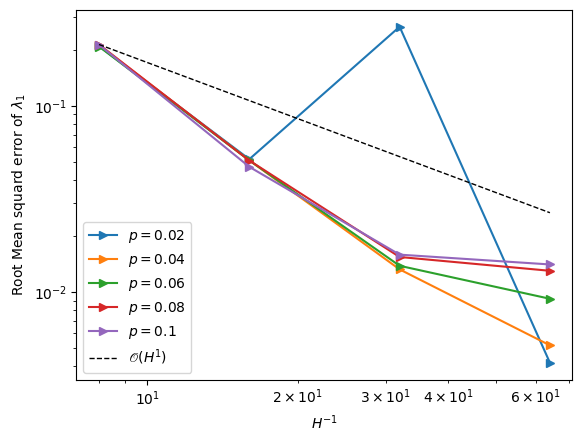

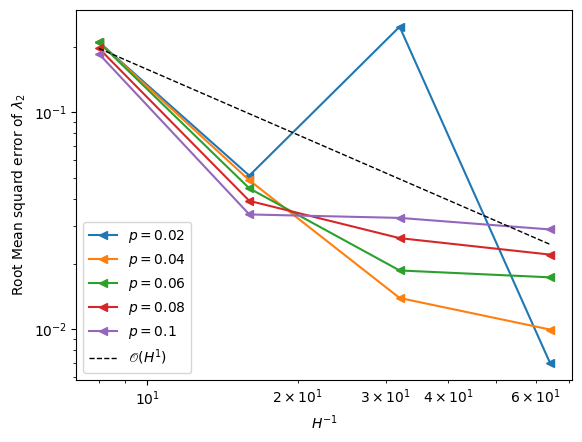

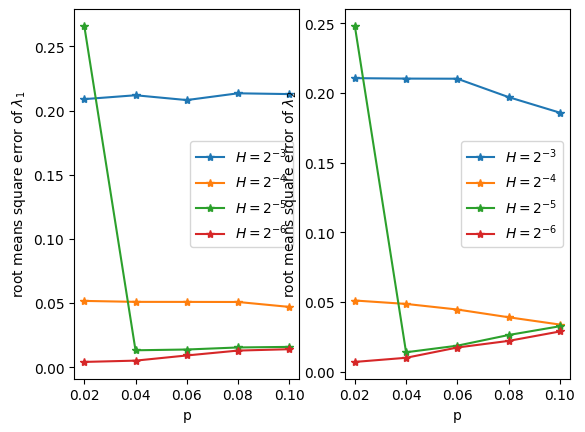

In [5]:
plots_cvg(root, H_Convergence=True, p_Convergence=True)

In [4]:
NFine = np.array([256])
Nepsilon = np.array([128])
NCoarse = np.array([4])
k=2
NSamples = 20
dim = np.size(NFine)
Neigen = 3
boundaryConditions = None
alpha = 0.1
beta = 1.
pList = [0.02,0.04,0.06,0.08,0.1]
np.random.seed(123)
model ={'name': 'check', 'alpha': alpha, 'beta': beta}
root = 'Data/Testing/OOk2/'

In [3]:
convergence(Neigen, NCoarse, NFine, Nepsilon, k, NSamples, pList,alpha,beta, model, solver = "KOOLOD", reference_solver="FEM", save_files = True, plot=False, root=root)

/home/kolombag/Documents/gridlod-random-perturbations/venv3/lib/python3.9/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Root mean square absolute error of λ1:
 [[0.21006248 0.20631409 0.21685392 0.21179729 0.20687876]
 [0.04989631 0.05150636 0.05484008 0.0468131  0.04560079]
 [0.0121798  0.01298217 0.01042312 0.01093288 0.02103184]
 [0.00323585 0.00758598 0.0118721  0.01654429 0.01670168]]
Root mean square absolute error of λ2: 
 [[0.21065098 0.21468459 0.20359115 0.19630197 0.18778361]
 [0.05356536 0.04815367 0.04238335 0.03176336 0.04050431]
 [0.01446037 0.01479172 0.01544839 0.02346147 0.02670774]
 [0.00380657 0.00995791 0.0162306  0.01912909 0.03516976]]


(None, None)

hplot [ 8 16 32 64]


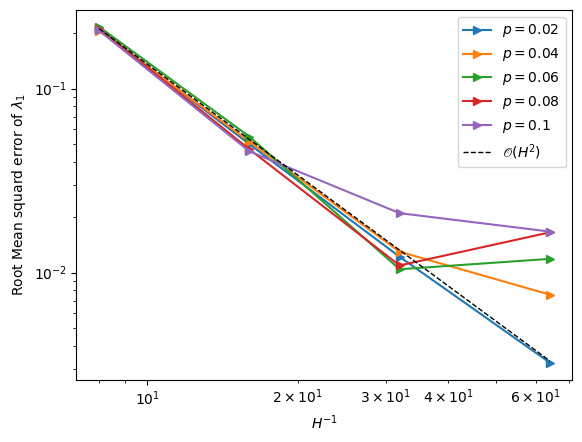

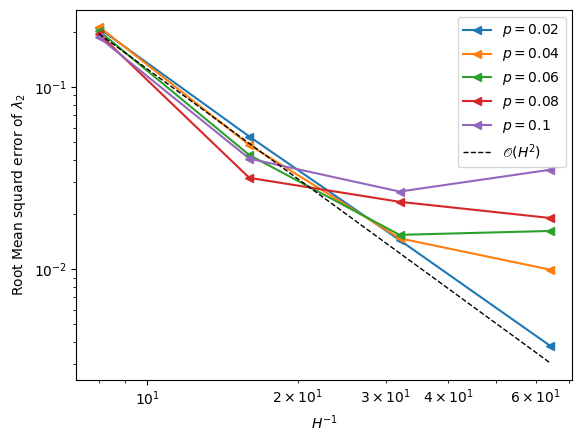

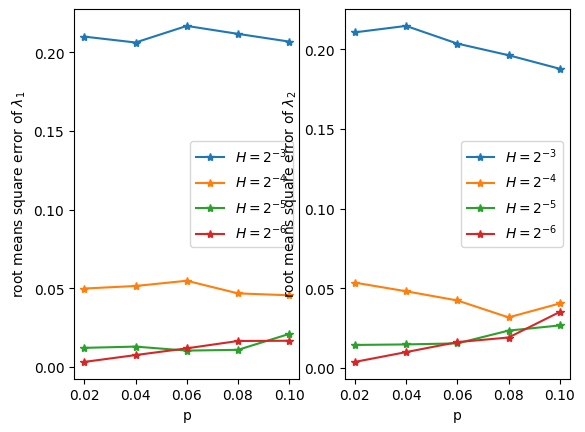

In [5]:
plots_cvg(root, H_Convergence=True, p_Convergence=True)

In [6]:
NFine = np.array([256])
Nepsilon = np.array([128])
NCoarse = np.array([4])
k=2
NSamples = 200
dim = np.size(NFine)
Neigen = 3
boundaryConditions = None
alpha = 0.1
beta = 1.
pList = [0.02,0.04,0.06,0.08,0.1]
np.random.seed(123)
model ={'name': 'check', 'alpha': alpha, 'beta': beta}
root = 'Data/Testing/N200_OOk2/'

In [7]:
convergence(Neigen, NCoarse, NFine, Nepsilon, k, NSamples, pList,alpha,beta, model, solver = "KOOLOD", reference_solver="FEM", save_files = True, plot=False, root=root)

/home/kolombag/Documents/gridlod-random-perturbations/venv3/lib/python3.9/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Root mean square absolute error of λ1:
 [[0.20888689 0.21190762 0.20815876 0.21342898 0.21282144]
 [0.05170348 0.05096097 0.05093016 0.05086584 0.04703973]
 [0.26592088 0.01324184 0.01384334 0.01543668 0.01588931]
 [0.0041768  0.00517801 0.00920758 0.01301415 0.01407429]]
Root mean square absolute error of λ2: 
 [[0.21064419 0.2103374  0.21024757 0.19705266 0.18590307]
 [0.05107938 0.04862843 0.04461893 0.03906692 0.03382689]
 [0.24813353 0.01393327 0.01866146 0.02630502 0.0326057 ]
 [0.00700822 0.00997074 0.01734944 0.02209085 0.02884694]]


(None, None)

In [ ]:
plots_cvg(root, H_Convergence=True, p_Convergence=True)